# Analyze Synthetic Grid Cells: Warping

### Imports & setup

In [2]:
import setup

setup.main()

import os

os.environ["GEOMSTATS_BACKEND"] = "pytorch"

import geomstats.backend as gs
import matplotlib.pyplot as plt
import numpy as np
from geomstats.geometry.pullback_metric import PullbackMetric
from viz import plot_grid_rate_maps, plot_grids

import neurometry.datasets.gridcells as gridcells

%load_ext autoreload
%autoreload 2
%matplotlib inline

Working directory:  /Users/facosta/Desktop/code/neurometry/neurometry/neuralwarp
Directory added to path:  /Users/facosta/Desktop/code/neurometry/neurometry
Directory added to path:  /Users/facosta/Desktop/code/neurometry/neurometry/neuralwarp
['/Users/facosta/Desktop/code/neurometry/neurometry/neuralwarp', '/Users/facosta/miniconda3/envs/neurometry/lib/python38.zip', '/Users/facosta/miniconda3/envs/neurometry/lib/python3.8', '/Users/facosta/miniconda3/envs/neurometry/lib/python3.8/lib-dynload', '', '/Users/facosta/miniconda3/envs/neurometry/lib/python3.8/site-packages', '/Users/facosta/Desktop/code/neurometry', '/Users/facosta/Desktop/code/neurometry/neurometry', '/Users/facosta/Desktop/code/neurometry/neurometry/neuralwarp']


INFO: Using pytorch backend


## Define diffeomorphism $\varphi: \mathbb{R}^2 \to \mathbb{R}^2$

$(x,y) \mapsto ((1 + \frac{\gamma}{(1 + x^2 + y^2)^{\alpha}})x, (1 + \frac{\gamma}{(1 + x^2 + y^2)^{\beta}})y)$

$\gamma \in \mathbb{R}, \alpha, \beta \in \mathbb{R}_{+}$ parameterize the deformation

In [3]:
def get_plane_warp(alpha, beta, gamma):
    def plane_warp(point):
        x = point[0]
        y = point[1]

        f_x = (1 + gamma / (1 + x**2 + y**2) ** alpha) * x
        f_y = (1 + gamma / (1 + x**2 + y**2) ** beta) * y

        return gs.array([f_x, f_y])

    return plane_warp

In [ ]:
# TODO: define inverse diffop

### Instantiate + plot warp

In [4]:
warp = get_plane_warp(alpha=2, beta=0.1, gamma=-0.4)

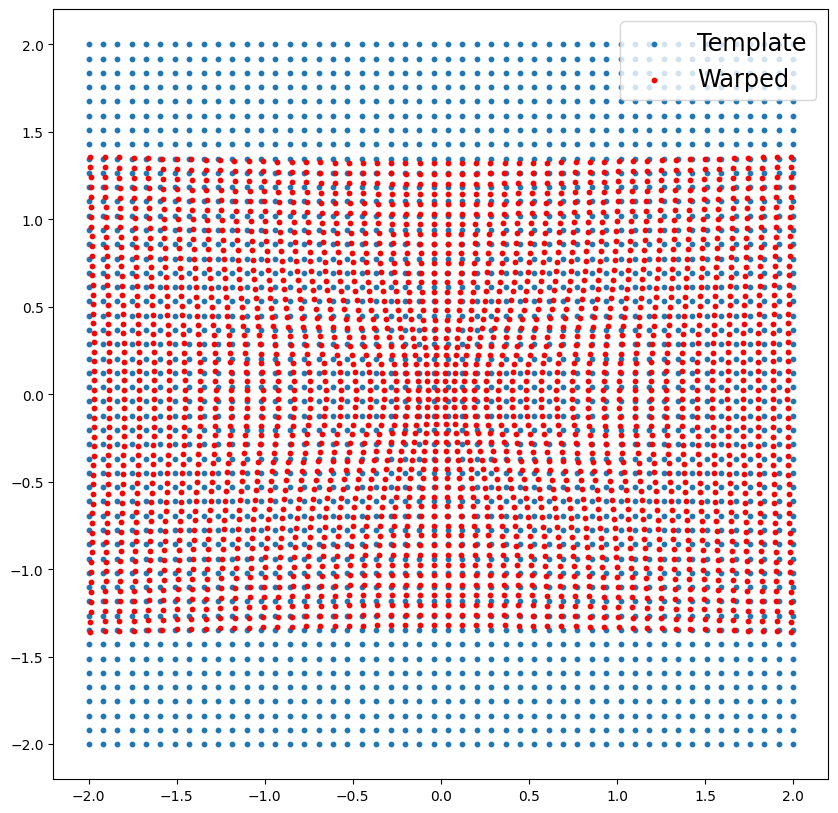

In [5]:
x = gs.linspace(-2, 2, 50)
y = gs.linspace(-2, 2, 50)
x_grid, y_grid = gs.meshgrid(x, y)
x_grid_warp, y_grid_warp = warp((x_grid, y_grid))
fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111)
ax.scatter(x_grid, y_grid, s=10, label="Template")
ax.scatter(x_grid_warp, y_grid_warp, s=10, label="Warped", c="red")
ax.legend(fontsize="xx-large")

## Compute pull-back metric $(\varphi^*g)_{ij} = \partial_{i}\varphi^{a}\partial_{j}\varphi^{b}g_{ab}$

In [44]:
pullback_metric = PullbackMetric(dim=2, embedding_dim=2, immersion=warp)

In [8]:
from geomstats.geometry.euclidean import Euclidean
from geomstats.geometry.pullback_metric import PullbackDiffeoMetric


class NeuralPullbackDiffeoMetric(PullbackDiffeoMetric):
    def __init__(self):
        super().__init__(space=Euclidean(dim=2))

    def _define_embedding_space(self):
        return Euclidean(dim=2)

    def diffeormorphism(self, base_point):
        return warp(base_point)

    def inverse_diffeormorphism(self, base_point):
        return warp(base_point)


pullback_diffeo_metric = NeuralPullbackDiffeoMetric()

TypeError: Can't instantiate abstract class NeuralPullbackDiffeoMetric with abstract methods define_embedding_metric, diffeomorphism, inverse_diffeomorphism

### Quick distance check 

In [33]:
point_a = gs.array([0.0, 0.0])
point_b = gs.array([1.0, 1.0])
pullback_metric.dist(point_a, point_b)

tensor(0.5221)

### Quick metric matrix check

In [34]:
pullback_metric.metric_matrix(point_a)

tensor([[0.2500, 0.0000],
        [0.0000, 0.2500]])

## Plot volume element $\sqrt{|\text{det}(g)|}$

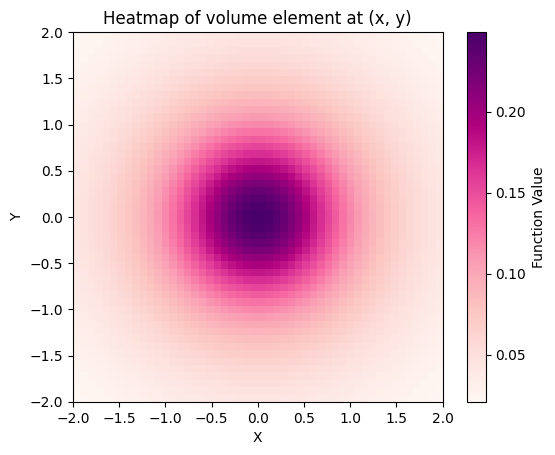

In [45]:
# Combine and reshape the x and y coordinates into a list of 2D points
points = gs.vstack((x_grid.ravel(), y_grid.ravel())).T


# Define your function
def volume_element(x, y):
    point = gs.array([x, y])
    g = pullback_metric.metric_matrix(point)
    return gs.sqrt(gs.abs(gs.linalg.det(g)))


# Apply the function to each point in the list
values = gs.array([volume_element(x, y) for x, y in points])

# Reshape the values back into a 2D grid
z_values = values.reshape(x_grid.shape)

# Create the heatmap
plt.imshow(
    z_values, origin="lower", extent=[x.min(), x.max(), y.min(), y.max()], cmap="RdPu"
)
plt.colorbar(label="Function Value")
plt.xlabel("X")
plt.ylabel("Y")
plt.title("Heatmap of volume element at (x, y)")
plt.show()

## Synthetic grid cell deformations

### Grid cell parameters

In [58]:
grid_scale = 0.15
arena_dims = np.array([4, 4])
n_cells = 1
grid_orientation_mean = 0
grid_orientation_std = 0
field_width = 0.1
resolution = 50
lx = grid_scale
ly = grid_scale * np.sqrt(3) / 2

### Create grid + deformed grid

In [59]:
grids, grids_warped = gridcells.generate_all_grids(
    grid_scale,
    lx,
    ly,
    arena_dims,
    n_cells,
    grid_orientation_mean,
    grid_orientation_std,
    warp=hyperbolic_wrap,
    lattice_type="square",
)

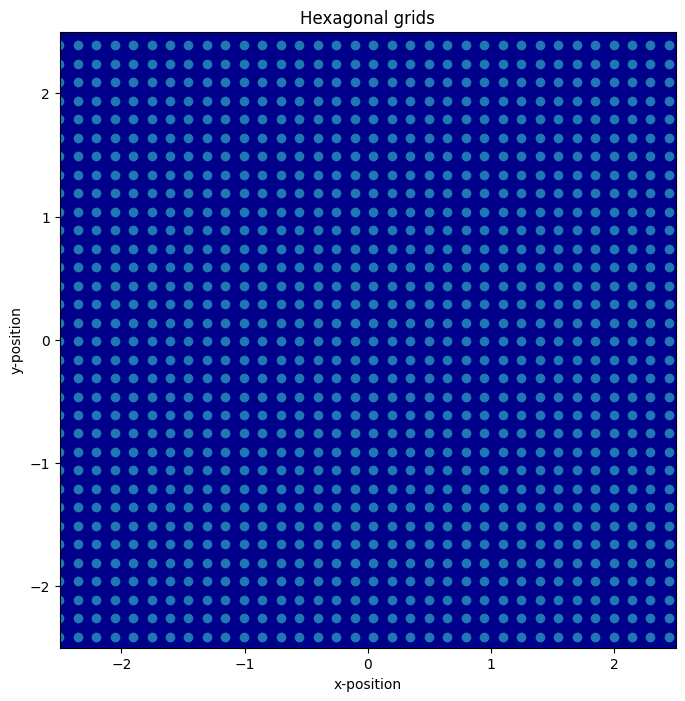

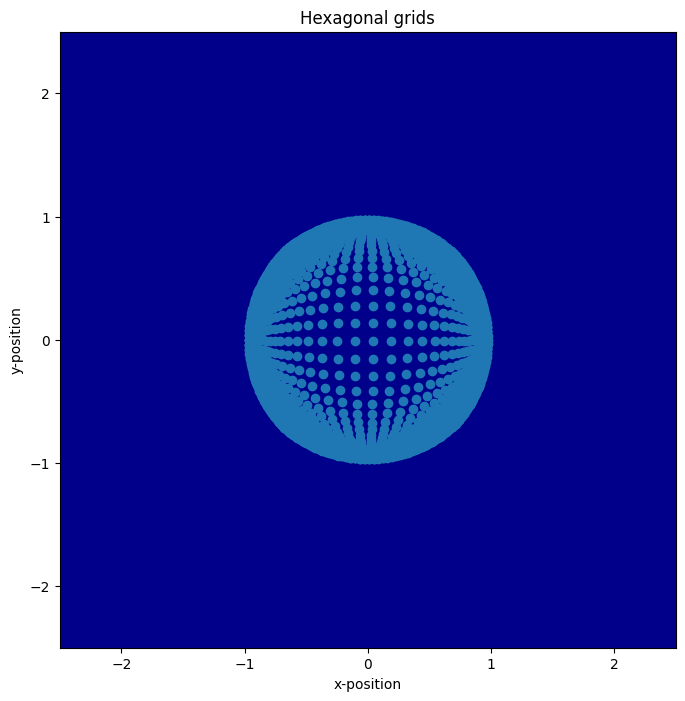

In [60]:
plot_grids(grids, arena_dims)
plot_grids(grids_warped, arena_dims)

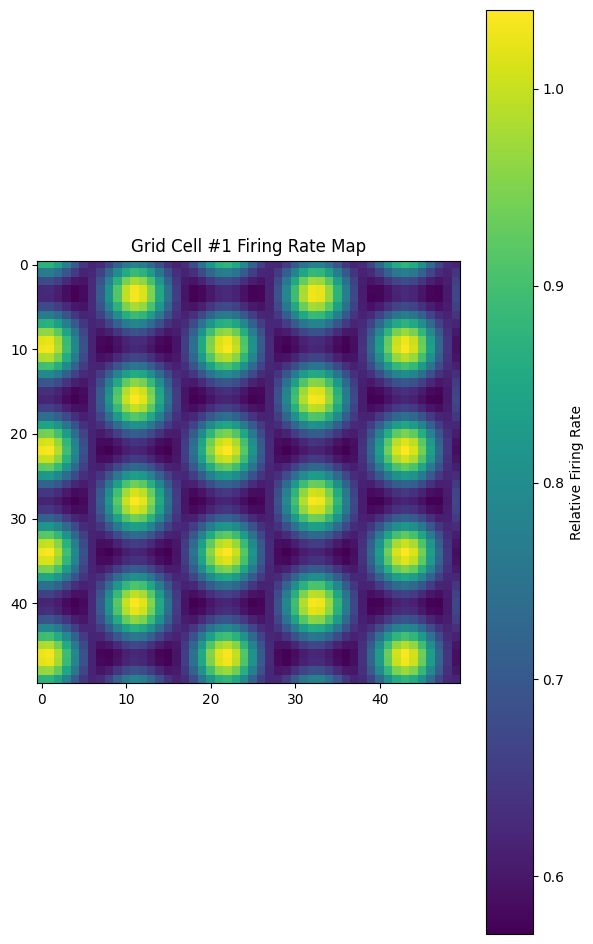

In [17]:
rate_maps = gridcells.create_rate_maps(grids, field_width, arena_dims, resolution)
plot_grid_rate_maps(rate_maps)

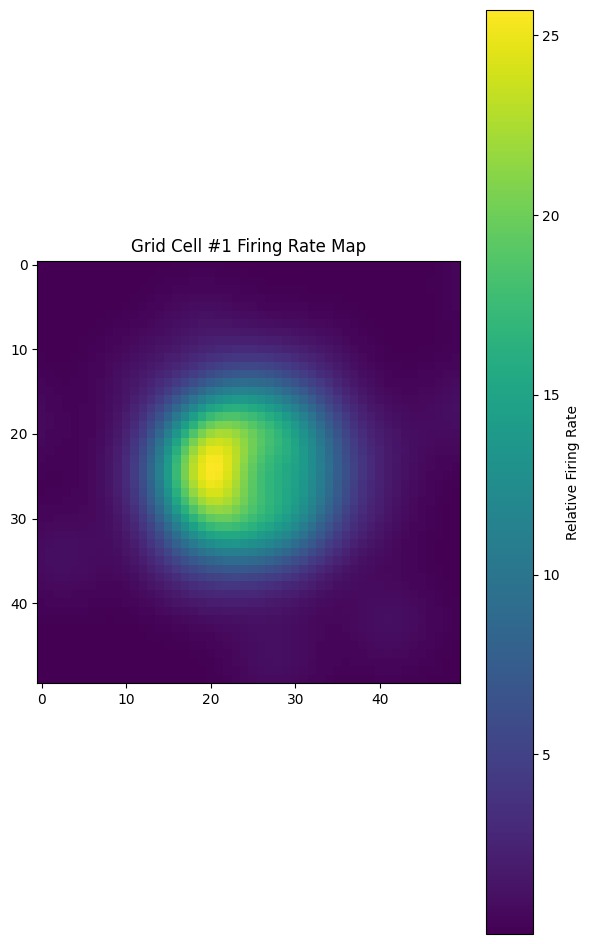

In [12]:
rate_maps_warped = gridcells.create_rate_maps(
    grids_warped, field_width, arena_dims, resolution
)
plot_grid_rate_maps(rate_maps_warped)

## Apply LDDMM algorithm to grid cell maps

In [16]:
import pyLDDMM
from pyLDDMM.utils.visualization import plot_warpgrid

In [17]:
i0 = rate_maps[0]

i1 = rate_maps_warped[0]

In [18]:
lddmm = pyLDDMM.LDDMM2D()
im, v, energies, length, Phi0, Phi1, J0, J1 = lddmm.register(
    i0, i1, sigma=0.1, alpha=1, epsilon=0.0001, K=500
)

iteration   0, energy 7356.55, thereof 0.00 regularization and 7356.55 intensity difference
iteration   1, energy 6838.51, thereof 3.54 regularization and 6834.97 intensity difference
iteration   2, energy 6367.28, thereof 6.96 regularization and 6360.32 intensity difference
iteration   3, energy 5938.25, thereof 10.25 regularization and 5928.00 intensity difference
iteration   4, energy 5547.29, thereof 13.42 regularization and 5533.88 intensity difference
iteration   5, energy 5190.54, thereof 16.47 regularization and 5174.07 intensity difference
iteration   6, energy 4861.58, thereof 19.41 regularization and 4842.16 intensity difference
iteration   7, energy 4557.26, thereof 22.25 regularization and 4535.01 intensity difference
iteration   8, energy 4275.87, thereof 24.97 regularization and 4250.89 intensity difference
iteration   9, energy 4016.48, thereof 27.59 regularization and 3988.88 intensity difference
iteration  10, energy 3778.18, thereof 30.12 regularization and 3748.06 i

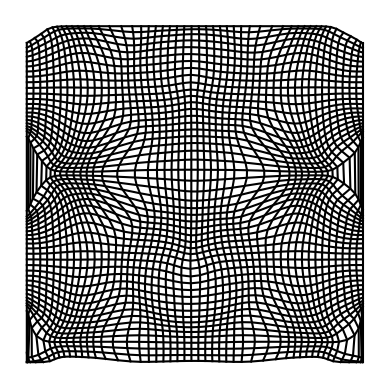

In [25]:
plot = plot_warpgrid(Phi0[-1], interval=1)